In [1]:
%run ../SAMI/utils.py
%run ../SAMI/preprocessing.py
%run ../SAMI/correlation.py
%run ../SAMI/clustering.py
%run ../SAMI/markers.py
%run ../SAMI/pathway.py
import warnings
warnings.filterwarnings("ignore")

# 1. Data Preprocessing

## 1.1 Convert .csv to .h5ad and split datasets by regions

In [6]:
data_path = '../datasets/' # set input dataset path

In [7]:
csv2h5ad(data_path,split=True) # convert .csv to .h5ad and split datasets by different regions (brain1,brain2...)

In [8]:
list_files(data_path,'','.h5ad')

['brain1_glycomics.h5ad',
 'brain2_metabolomics.h5ad',
 'brain1_lipidomics.h5ad',
 'brain2_glycomics.h5ad',
 'brain_lipidomics.h5ad',
 'brain_glycomics.h5ad',
 'brain2_lipidomics.h5ad',
 'brain_metabolomics.h5ad',
 'brain1_metabolomics.h5ad']

## 1.2 Pool three omics data

In [9]:
pooldata(data_path,split=True) # merge metabolomics, lipidomics and glycomics data by coordinates (x,y) of pixel and split by different regions (brain1, brain2...)

In [10]:
list_files(data_path,'pool','.h5ad')

['brain1_pool.h5ad', 'brain2_pool.h5ad', 'brain_pool.h5ad']

# 2. Correlation Investigation

## 2.1 Correlation plot

In [11]:
# load metabolomics and lipidomics data of brain2
adata1=sc.read(data_path+'brain2_metabolomics.h5ad')
adata2=sc.read(data_path+'brain2_lipidomics.h5ad')

In [12]:
#calculate the correlation between m.z. from two omics
corr = calculate_corr(adata1,adata2)

In [13]:
corr.head()

omic1        omic2      corr
0  m.z.78.958  m.z.327.234 -0.542189
1  m.z.78.958  m.z.328.237 -0.447526
2  m.z.78.958  m.z.331.265 -0.356400
3  m.z.78.958  m.z.346.056 -0.645435
4  m.z.78.958   m.z.347.04 -0.655738

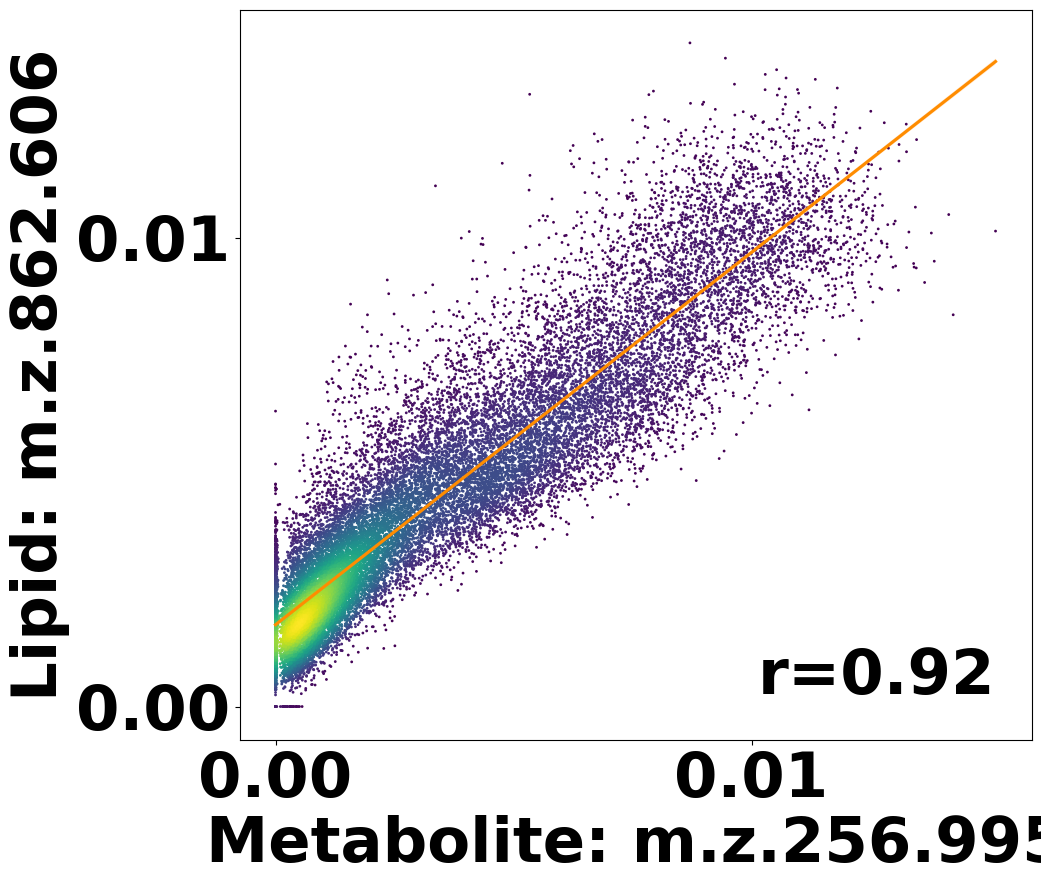

In [14]:
corr_plot(adata1,adata2,'m.z.256.995','m.z.862.606',xomic='Metabolite',yomic='Lipid')

## 2.2 Correlation network

In [15]:
adata = sc.read(data_path+'brain2_pool.h5ad') #load pool dataset (triple-omics) of brain2
data = adata_filter(adata,abundance=0,prevalence=0.95).to_df() #filter out m.z with prevalence smaller than 0.95

corr_matrix = data.corr() ## calculate correlation intra and inter omics
corr_df = pd.DataFrame(data=corr_matrix, index=data.columns, columns=data.columns)

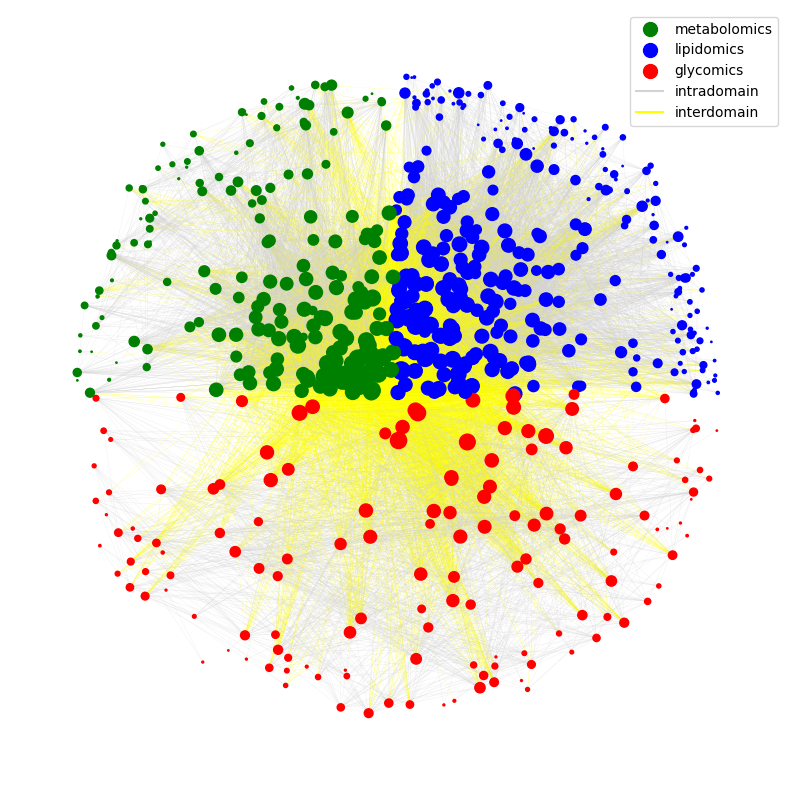

In [16]:
corr_network(adata,corr_df) #plot correlation network

# 3. Clustering

## 3.1 Brain1

In [17]:
cluster('brain1_pool.h5ad',res=1.4) #perform clustering on brain1 pool data with resolution=1.4

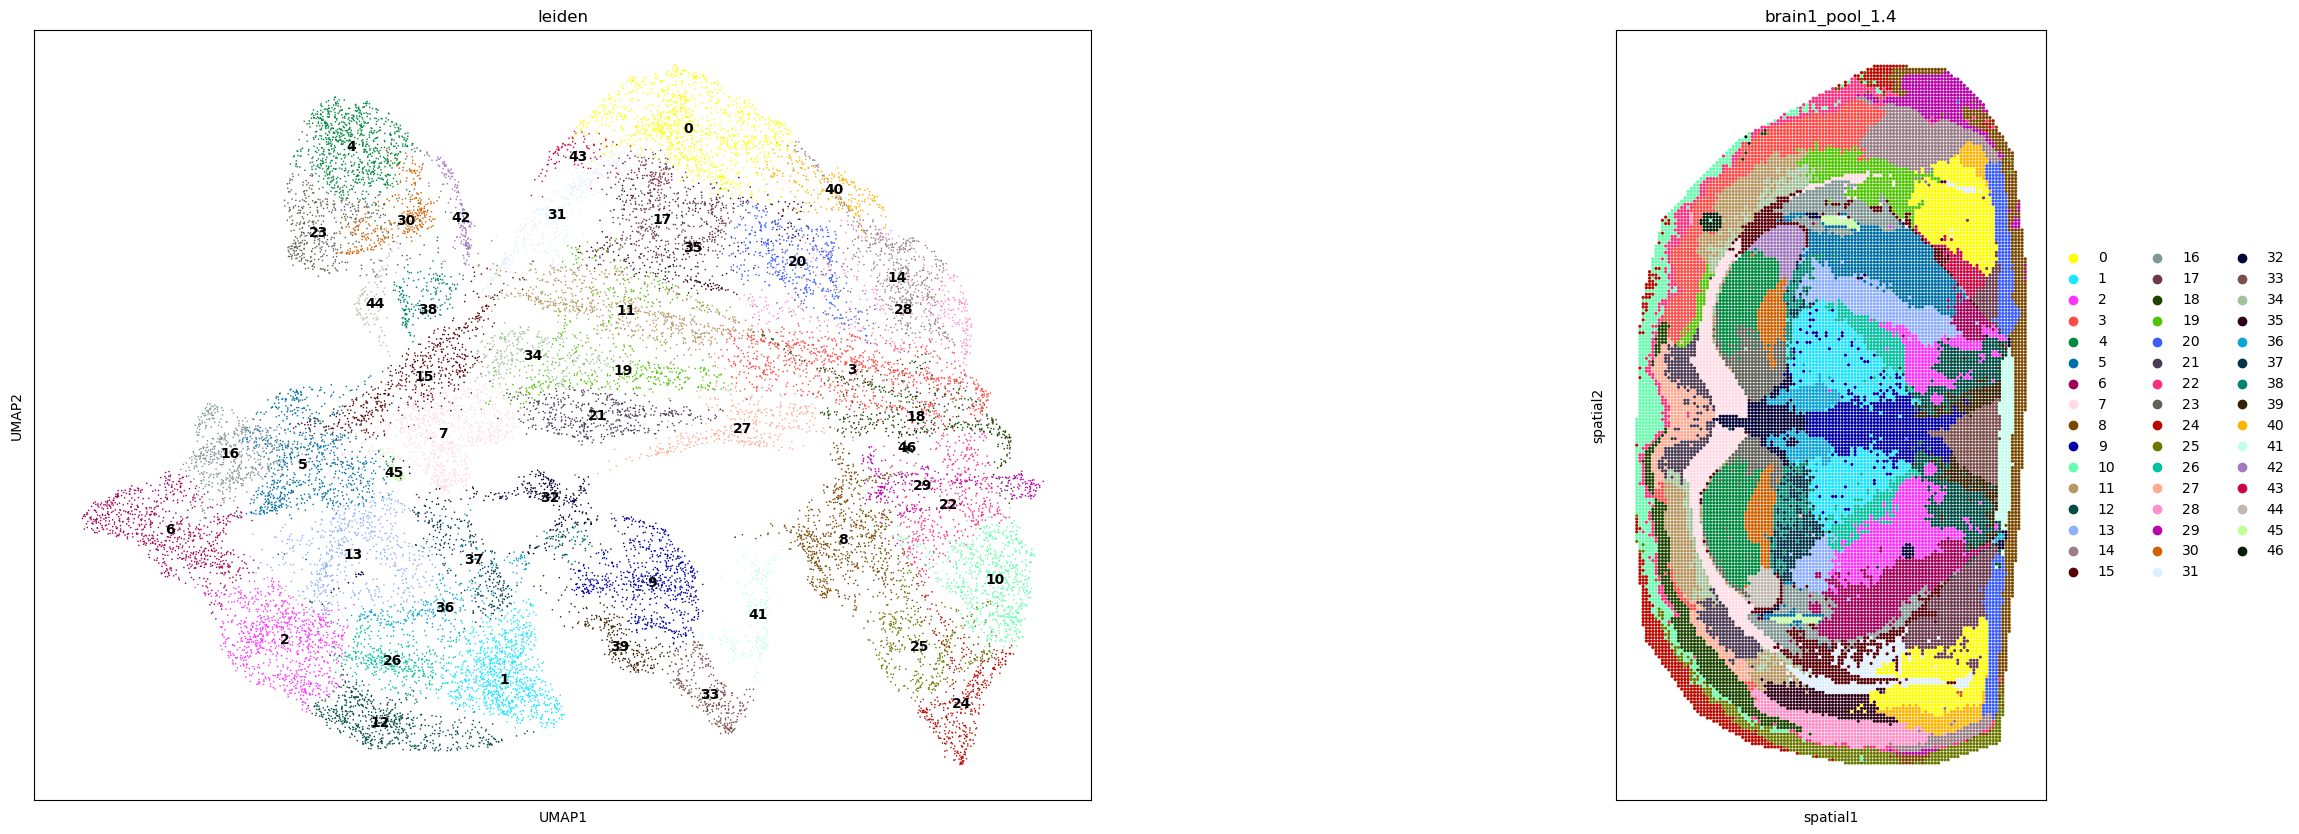

In [18]:
plot_umap_cluster('brain1_pool_1.4.h5ad') # display UMAP and spatial mapping

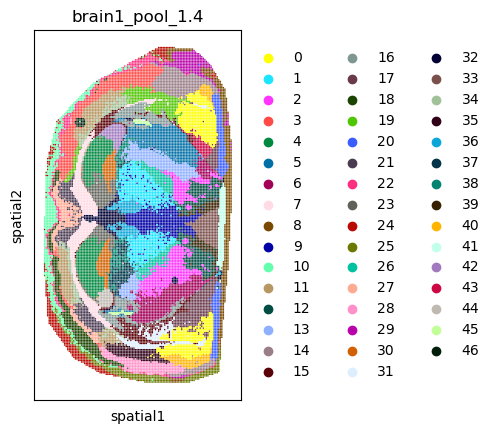

In [19]:
plot_cluster('brain1_pool_1.4.h5ad') #display spatial mapping only

## 3.2 Brain2

In [20]:
cluster('brain2_pool.h5ad',res=1.4) #perform clustering on brain2 pool data with resolution=1.4

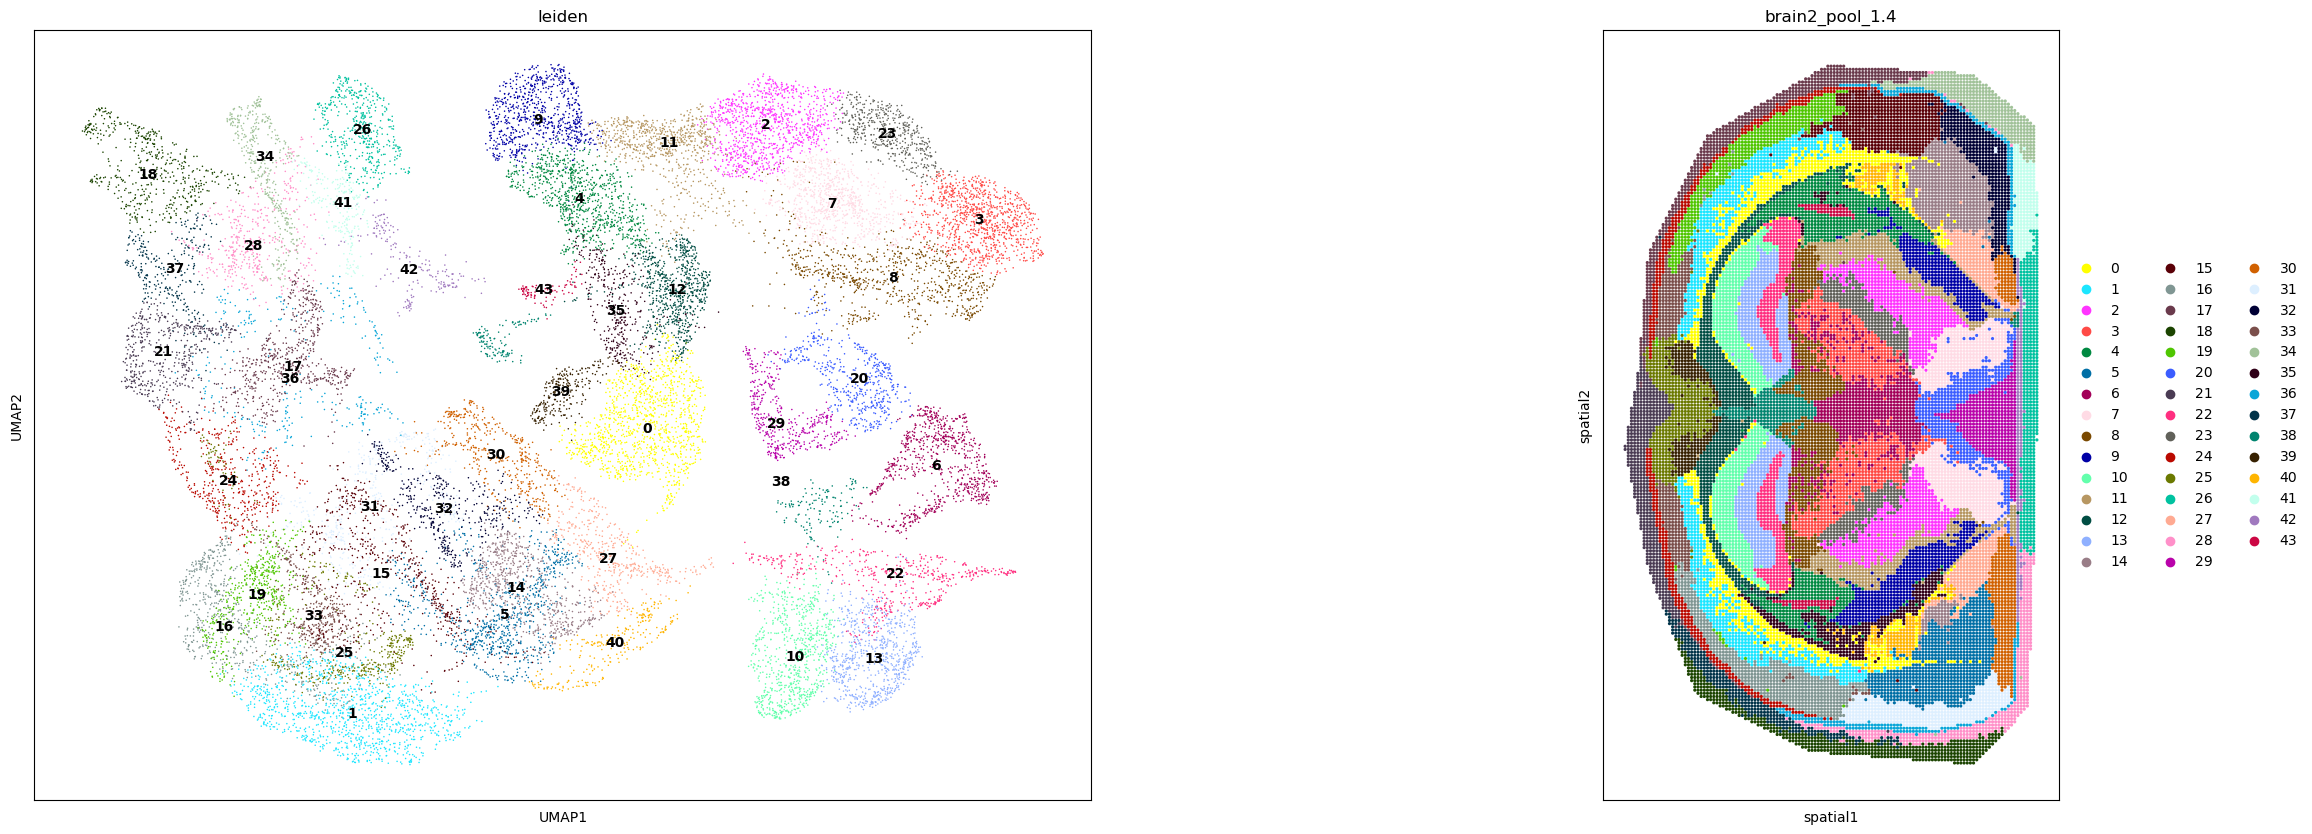

In [21]:
plot_umap_cluster('brain2_pool_1.4.h5ad') # display UMAP and spatial mapping

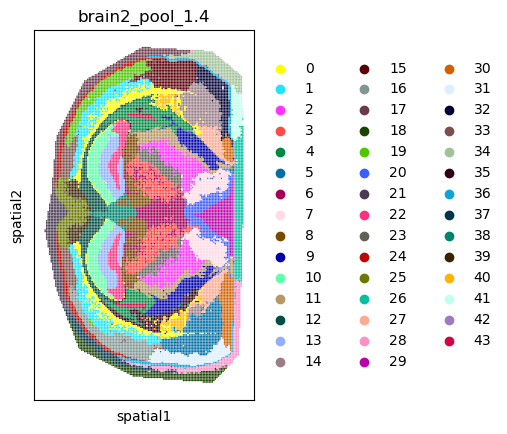

In [22]:
plot_cluster('brain2_pool_1.4.h5ad') #display spatial mapping only

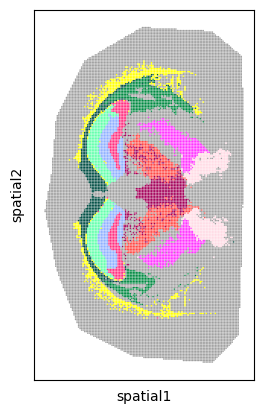

In [23]:
# display selected clusters only
clusters = sorted([12,10,13,22,0,6,3,4,7,2]) 
plot_select_cluster('brain2_pool_1.4.h5ad',cluster=clusters)

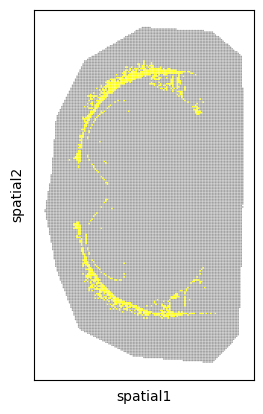

In [24]:
plot_select_cluster('brain2_pool_1.4.h5ad',cluster=[0])

## 3.3 Merge clusters

In [25]:
merge_dict = {'a':[19,1,0,33],'b':[6,8,3,23],'c':[20,7,2,11,29],'d':[14,27],'e':[30,32]} # create a dictionary for clusters merging
merge_cluster('brain2_pool_1.4.h5ad',merge_dict) # merge clusters based on merge dictionary, the merged clusters will be saved in original .h5ad file

In [26]:
adata = sc.read(os.path.join('../results/clustering','brain2_pool_1.4.h5ad')) # load data with merged clusters

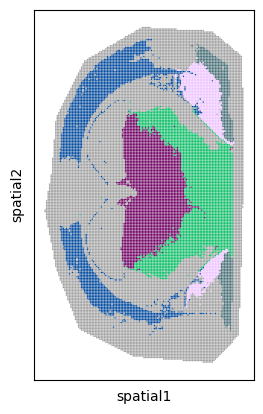

In [27]:
plot_select_cluster('brain2_pool_1.4.h5ad',cluster=['a','b','c','d','e'],merge_cluster=True) # plot spatial mapping for merged clusters

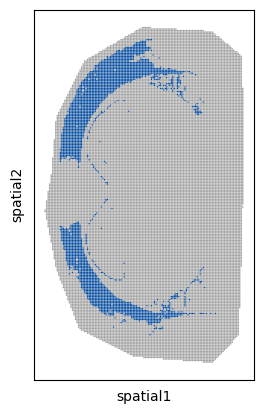

In [28]:
plot_select_cluster('brain2_pool_1.4.h5ad',cluster=['a'],merge_cluster=True)

# 4. Markers

In [ ]:
## Notice: Finding markers (4.1-4.3) is time-consuming (1.5-2 hour)

In [48]:
# load annotations
metab_ann = pd.read_csv('../annotation/metabolomics_annotation.csv')
lipid_ann = pd.read_csv('../annotation/lipidomics_annotation.csv')
glycan_ann = pd.read_csv('../annotation/glycomics_annotation.csv')

## 4.1 Brain1

In [50]:
adata = sc.read('../results/clustering/brain1_pool_1.4.h5ad') #load data

cluster = adata.obs[['leiden']] #select cluster type ('leiden' represents original clusters, 'merge' represents merged clusters, see 4.3 for merged clusters)

In [51]:
adata1 = sc.read('../datasets/brain1_metabolomics.h5ad') # load single omic data

adata1 = cluster_assign(adata1,cluster) #assign clusters obtained from triple omics data to single omic data

adata1_filter = adata_filter(adata1,0.1,0.1) #filter out pixels (abundance<0.1) and m.z. (prevalence <0.1)

findmarkers(adata = adata1_filter,samplename = 'brain1_metabolomics',top=50,adj_pval_cutoff=0.05,annotation=metab_ann) # Find markers for each cluster

In [52]:
adata2 = sc.read(data_path+'brain1_lipidomics.h5ad')

adata2 = cluster_assign(adata2,cluster)

adata2_filter = adata_filter(adata2,0.1,0.1)

findmarkers(adata2_filter,'brain1_lipidomics',top=50,adj_pval_cutoff=0.05,annotation=lipid_ann)

In [53]:
adata3 = sc.read(data_path+'brain1_glycomics.h5ad')

adata3 = cluster_assign(adata3,cluster)

adata3_filter = adata_filter(adata3,0.1,0.1)

findmarkers(adata3_filter,'brain1_glycomics',top=50,adj_pval_cutoff=0.05,annotation=glycan_ann)

## 4.2 Brain2

In [54]:
adata = sc.read('../results/clustering/brain2_pool_1.4.h5ad')

cluster = adata.obs[['leiden']]

In [55]:
adata1 = sc.read('../datasets/brain2_metabolomics.h5ad')

adata1 = cluster_assign(adata1,cluster)

adata1_filter = adata_filter(adata1,0.1,0.1)

findmarkers(adata1_filter,'brain2_metabolomics',top=50,adj_pval_cutoff=0.05,annotation=metab_ann)

In [56]:
adata2 = sc.read(data_path+'brain2_lipidomics.h5ad')

adata2 = cluster_assign(adata2,cluster)

adata2_filter = adata_filter(adata2,0.1,0.1)

findmarkers(adata2_filter,'brain2_lipidomics',top=50,adj_pval_cutoff=0.05,annotation=lipid_ann)

In [57]:
adata3 = sc.read(data_path+'brain2_glycomics.h5ad')

adata3 = cluster_assign(adata3,cluster)

adata3_filter = adata_filter(adata3,0.1,0.1)

findmarkers(adata3_filter,'brain2_glycomics',top=50,adj_pval_cutoff=0.05,annotation=glycan_ann)

## 4.3 Brain2 (Merged)

In [58]:
adata = sc.read('../results/clustering/brain2_pool_1.4.h5ad')

cluster = adata.obs[['merge']] # select 'merge' cluster type

In [59]:
adata1 = sc.read('../datasets/brain2_metabolomics.h5ad')

adata1 = cluster_assign(adata1,cluster)

adata1_filter = adata_filter(adata1,0.1,0.1)

findmarkers(adata1_filter,'brain2_metabolomics',top=50,adj_pval_cutoff=0.05,annotation=metab_ann,merge_cluster=True)

In [60]:
adata2 = sc.read(data_path+'brain2_lipidomics.h5ad')

adata2 = cluster_assign(adata2,cluster)

adata2_filter = adata_filter(adata2,0.1,0.1)

findmarkers(adata2_filter,'brain2_lipidomics',top=50,adj_pval_cutoff=0.05,annotation=lipid_ann,merge_cluster=True)

In [61]:
adata3 = sc.read(data_path+'brain2_glycomics.h5ad')

adata3 = cluster_assign(adata3,cluster)

adata3_filter = adata_filter(adata3,0.1,0.1)

findmarkers(adata3_filter,'brain2_glycomics',top=50,adj_pval_cutoff=0.05,annotation=glycan_ann,merge_cluster=True)

## 4.4 Circular Tree

In [29]:
# Add the Graphviz\bin folder to your user or system PATH after installation to use Graphviz
graphviz_path = '/blue/li.chen1/xin.ma/conda/envs/maldi/bin'
os.environ['PATH'] += os.pathsep + graphviz_path 
print(os.environ['PATH'])

/apps/jupyter/6.5.2/bin:/apps/ufrc/ufhpc/bin:/apps/git/2.30.1/bin:/opt/slurm/bin:/usr/lib64/qt-3.3/bin:/usr/local/cuda/bin:/opt/bin:/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/puppetlabs/bin:/home/xin.ma/bin:/blue/li.chen1/xin.ma/conda/envs/maldi/bin


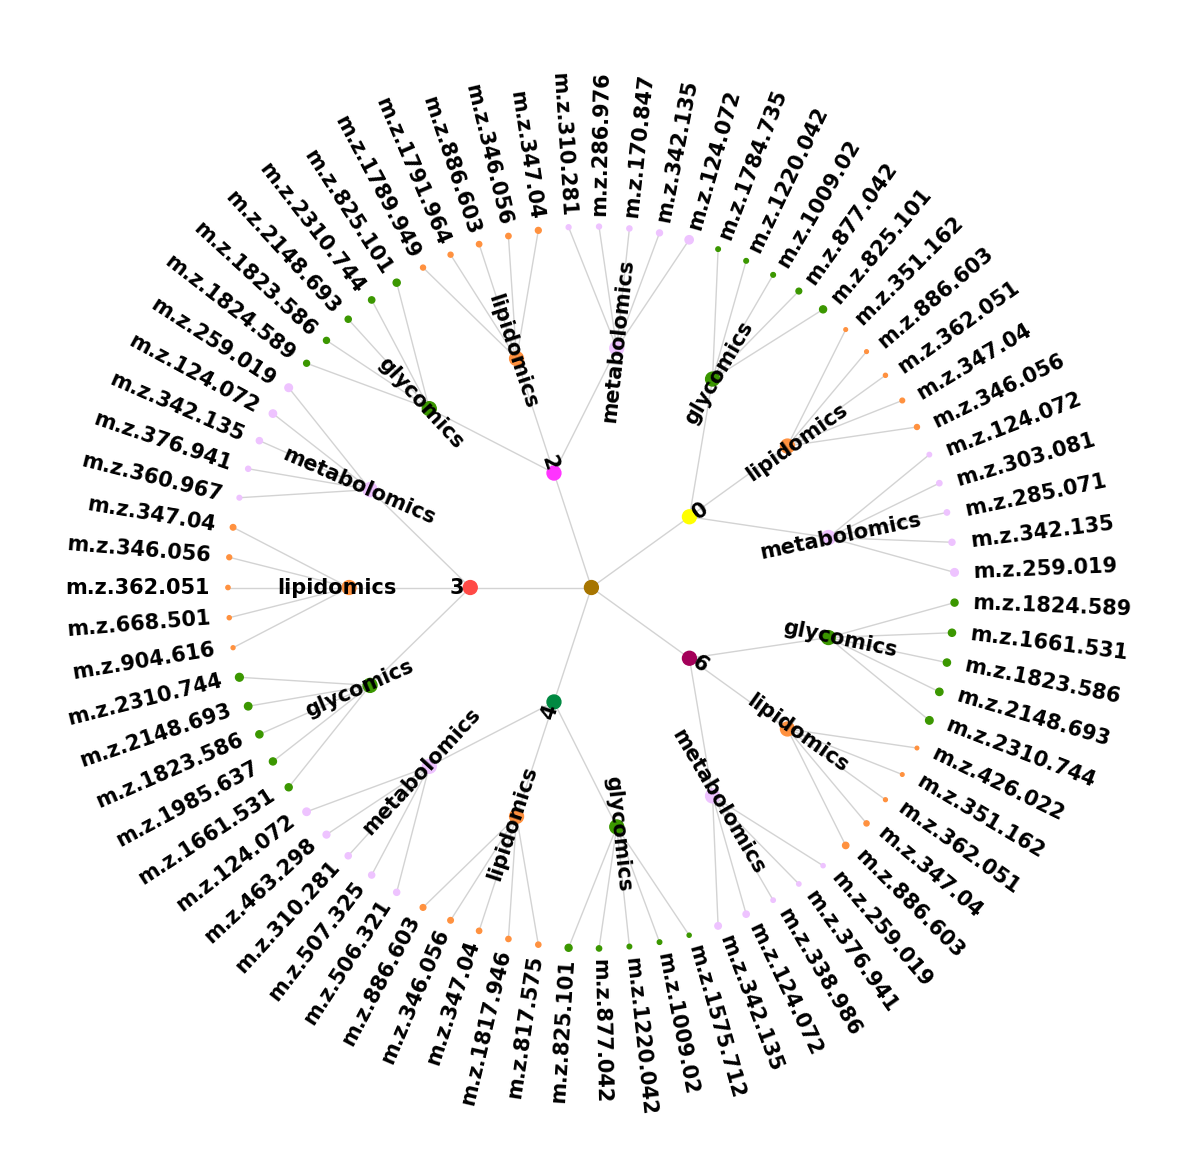

In [30]:
circular_tree(markerfile='markers.xlsx',section='brain2',clusters=[0,2,3,4,6],top=5) #plot the circular tree for selected clusters of brain2

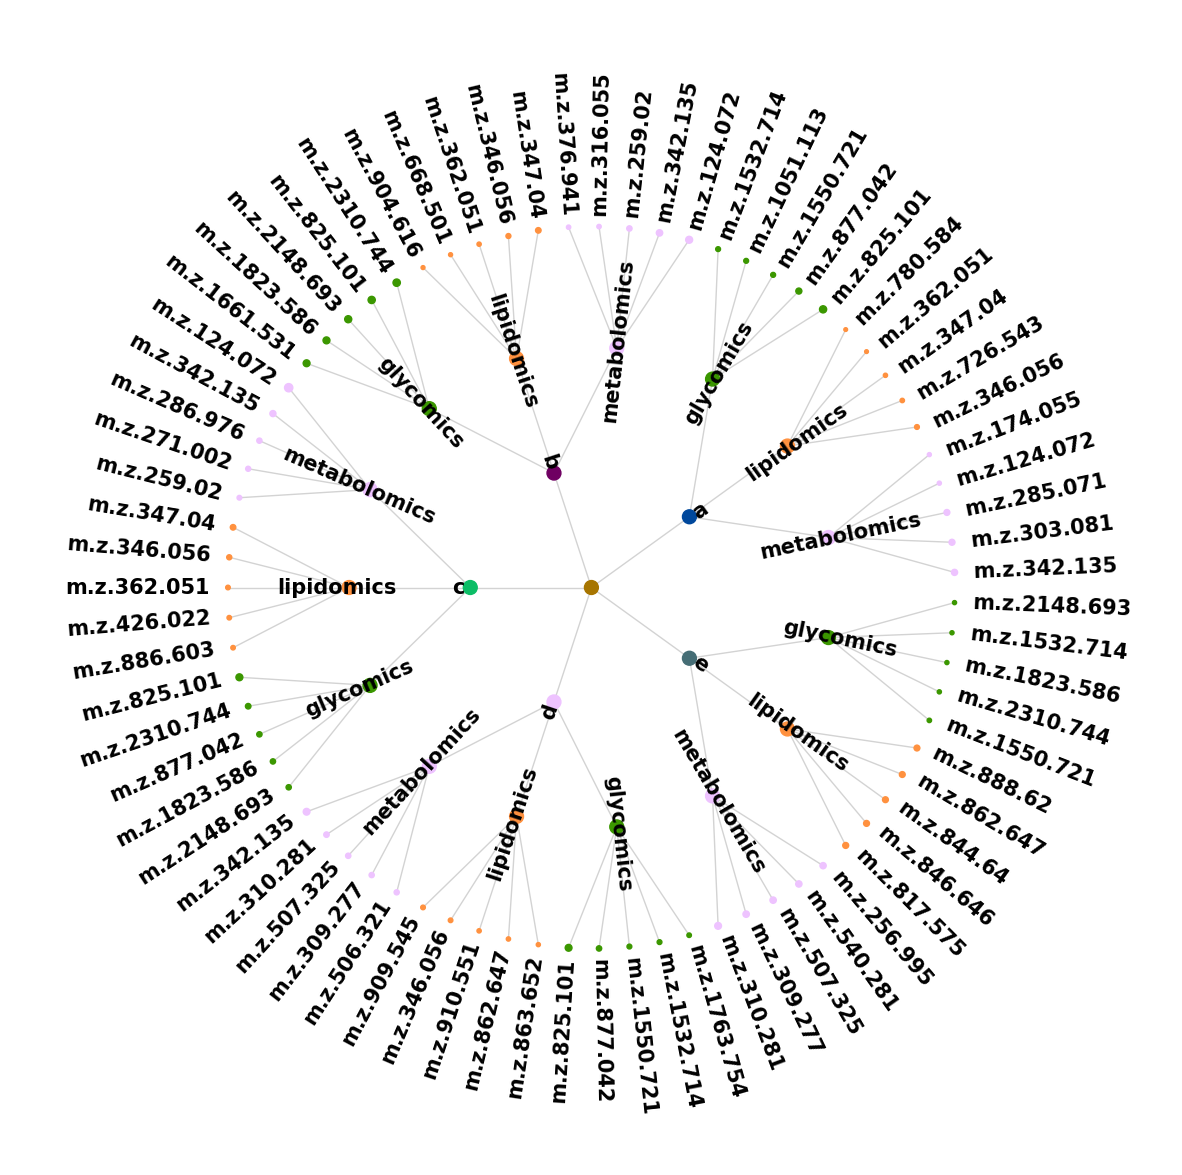

In [31]:
circular_tree('markers_merge.xlsx','brain2',['a','b','c','d','e']) #plot the circular tree for merged clusters of brain2

## 4.5 Volcano Plot

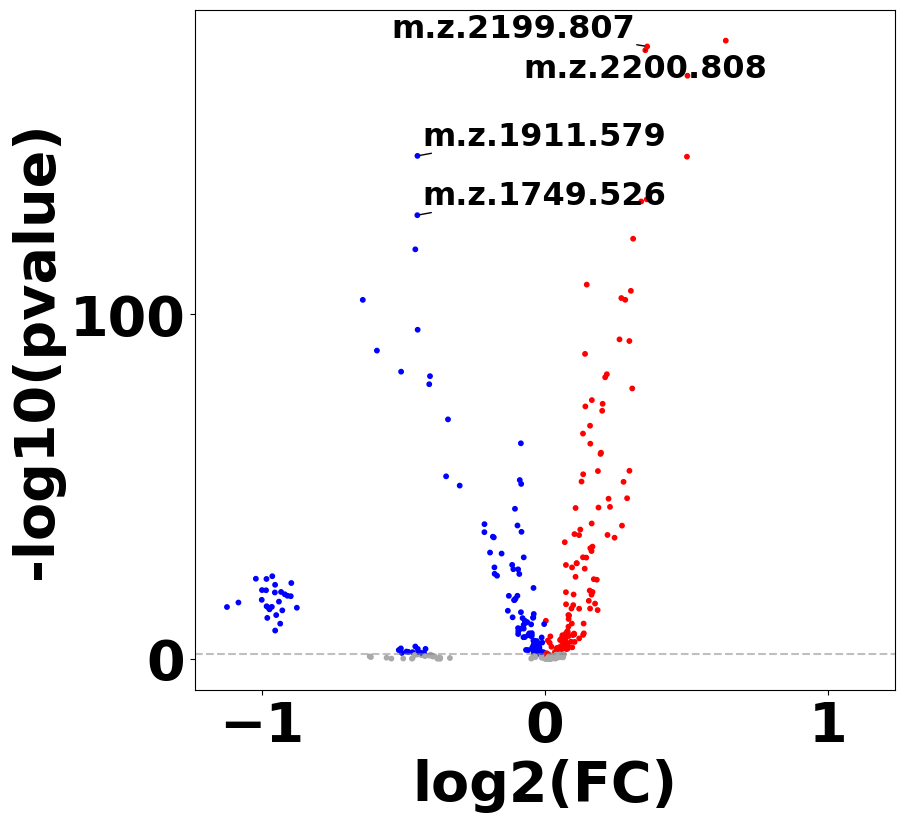

In [32]:
volcano_plot(pvaluefile='pvalues.xlsx',section='brain2',omics='metabolomics',cluster=6) #Plot volcano plot for metabolomics of cluster 6 in brain2

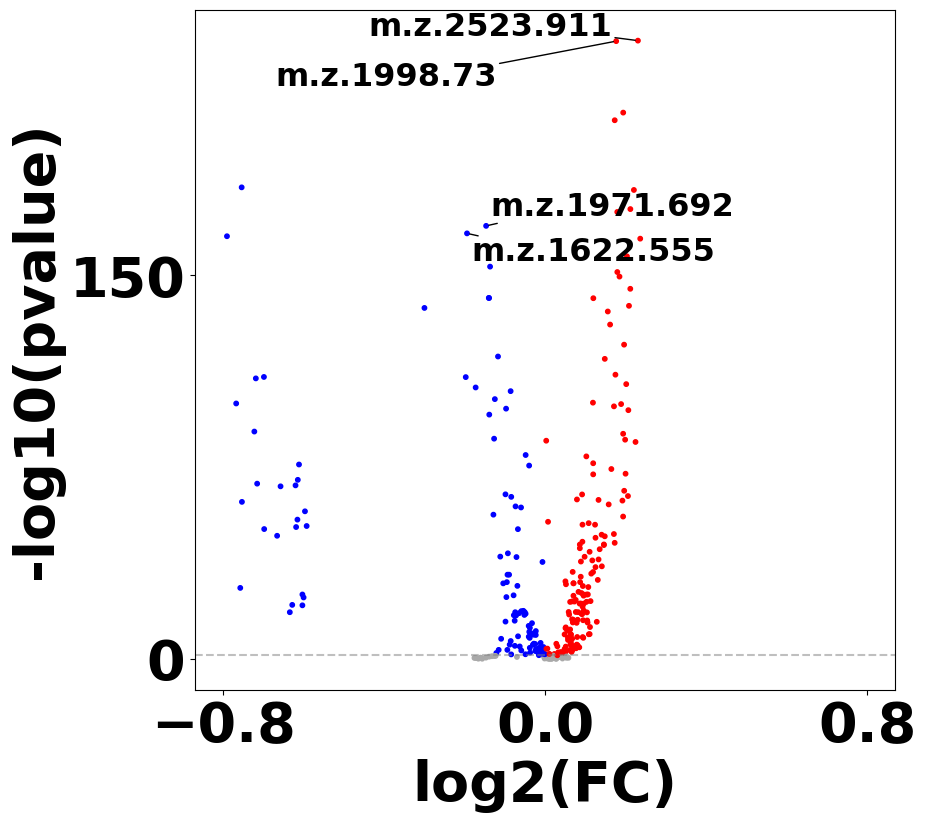

In [33]:
volcano_plot('pvalues_merge.xlsx','brain2','metabolomics','a')

## 4.6 Density Plot

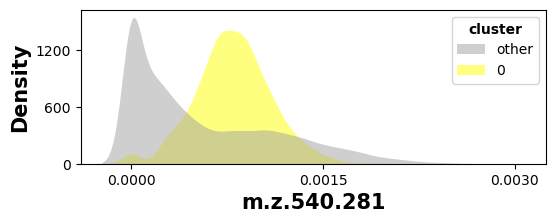

In [34]:
density_plot(adata1='brain2_pool_1.4.h5ad',adata2='brain2_metabolomics.h5ad',cluster=0,marker='m.z.540.281')
# Plot density plot for the metabolomics marker 'm.z.540.281' of cluster0 in brain2 using the clusters from brain2_pool_1.4.h5ad

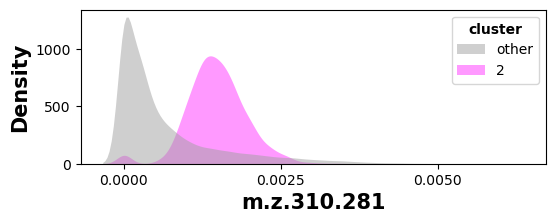

In [35]:
density_plot('brain2_pool_1.4.h5ad','brain2_metabolomics.h5ad',2,'m.z.310.281')

## 4.7 Clusters mapping: Brain1(validation) Brain2(discovery)

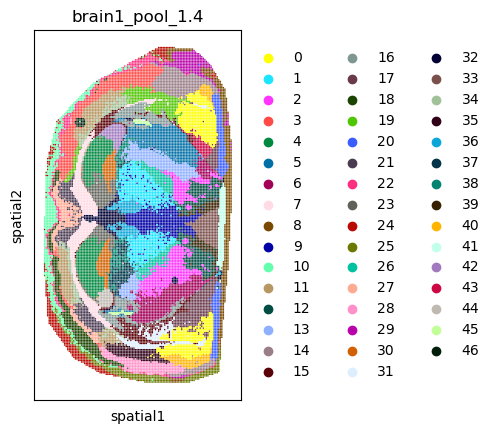

In [36]:
# brain1 before mapping
plot_cluster('brain1_pool_1.4.h5ad')

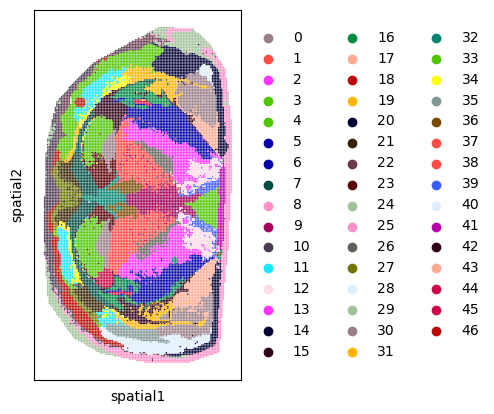

In [39]:
cluster_mapping(test='brain1',ref='brain2',testadata='brain1_pool_1.4.h5ad',markerfile='markers.xlsx')
# Plot spatial mapping figure after mapping brain1 to brain2

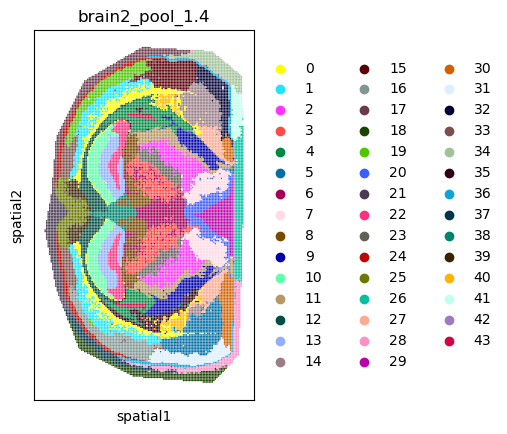

In [40]:
plot_cluster('brain2_pool_1.4.h5ad') #Plot brain2 to compare with mapped brain1. they have similar patterns.

# 5. Pathway Enrichment Analysis

## 5.1 Run MetaboAnalystR

In [43]:
os.environ['R_HOME']="/blue/li.chen1/xin.ma/conda/envs/maldi/lib/R"
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
r_source = ro.r['source']
r_source('../SAMI/MetabAnalystR.R')  

<rpy2.robjects.vectors.ListVector object at 0x2b39fbaed7c0> [RTYPES.VECSXP]
R classes: ('list',)
[SexpClosure, BoolSexpVector]
  value: <class 'rpy2.rinterface.SexpClosure'>
  <rpy2.rinterface.SexpClosure object at 0x2b39dbafcfc0> [RTYPES.CLOSXP]
  visible: <class 'rpy2.rinterface.BoolSexpVector'>
  <rpy2.rinterface.BoolSexpVector object at 0x2b39faf60340> [RTYPES.LGLSXP]

In [44]:
#metabolomics and glycomics
clusters = [0,2,3,4,6,7,10,12,13,22]
markers1 = pd.read_excel('../results/markers/markers.xlsx',sheet_name='brain2_metabolomics') #load brain2_metabolomics markers
markers2 = pd.read_excel('../results/markers/markers.xlsx',sheet_name='brain2_glycomics') #load brain2_lipidomics markers
markers = pd.concat([markers1,markers2],ignore_index=True) #combine them together
markers = markers.loc[(~markers['Name'].str.startswith('m.z.'))&(markers['cluster'].isin(clusters))] #filter selected clusters

In [45]:
logical_arg = ro.BoolVector([True,False])
clustersR = ro.vectors.IntVector(clusters)
with localconverter(ro.default_converter + pandas2ri.converter):
    markersR = ro.conversion.py2rpy(markers)

In [46]:
PathwayEnrichment = ro.r['PathwayEnrichment']

In [47]:
PathwayEnrichment(markers=markersR,clusters=clustersR,lipid=logical_arg[1],merge=logical_arg[1])

[1] "MetaboAnalyst R objects initialized ..."
[1] "1"                                                                              
[2] "Name matching OK, please inspect (and manual correct) the results then proceed."
[1] "MetaboAnalyst R objects initialized ..."
[1] "1"                                                                              
[2] "Name matching OK, please inspect (and manual correct) the results then proceed."
########## In cluster 2 An Error occured: incorrect number of dimensions 
[1] "MetaboAnalyst R objects initialized ..."
[1] "1"                                                                              
[2] "Name matching OK, please inspect (and manual correct) the results then proceed."
[1] "MetaboAnalyst R objects initialized ..."
[1] "1"                                                                              
[2] "Name matching OK, please inspect (and manual correct) the results then proceed."
########## In cluster 4 An Error occured: incorrect nu

<rpy2.rinterface_lib.sexp.NULLType object at 0x2b39fbd61100> [RTYPES.NILSXP]

In [48]:
#lipidomics
clusters = [0,2,3,4,6,7,10,12,13,22]
markers = pd.read_excel('../results/markers/markers.xlsx',sheet_name='brain2_lipidomics')
markers = markers.loc[(~markers['Name'].str.startswith('m.z.'))&(markers['cluster'].isin(clusters))]

In [49]:
logical_arg = ro.BoolVector([True,False])
clustersR = ro.vectors.IntVector(clusters)
with localconverter(ro.default_converter + pandas2ri.converter):
    markersR = ro.conversion.py2rpy(markers)

In [50]:
PathwayEnrichment = ro.r['PathwayEnrichment']

In [51]:
PathwayEnrichment(markers=markersR,clusters=clustersR,lipid=logical_arg[0],merge=logical_arg[1])

[1] "MetaboAnalyst R objects initialized ..."
[1] "0"                                                                                                                                                                                      
[2] "Over half of the compound IDs could not be matched to our database. Please make \n                                    sure that correct compound IDs or common compound names are used."
########## In cluster 0 An Error occured: could not find function "AddErrMsg" 
[1] "MetaboAnalyst R objects initialized ..."
[1] "1"                                                                              
[2] "Name matching OK, please inspect (and manual correct) the results then proceed."
[1] "MetaboAnalyst R objects initialized ..."
[1] "1"                                                                              
[2] "Name matching OK, please inspect (and manual correct) the results then proceed."
[1] "MetaboAnalyst R objects initialized ..."
[1] "1"      

<rpy2.rinterface_lib.sexp.NULLType object at 0x2b39fbd61100> [RTYPES.NILSXP]

## 5.2 Dot plot

In [52]:
ora_results = pd.read_csv('../results/pathway/ora_metgly.csv',index_col=0) #load results from Pathway Enrichment analysis
ora_results['enrichment_ratio'] = ora_results['hits']/ora_results['expected']

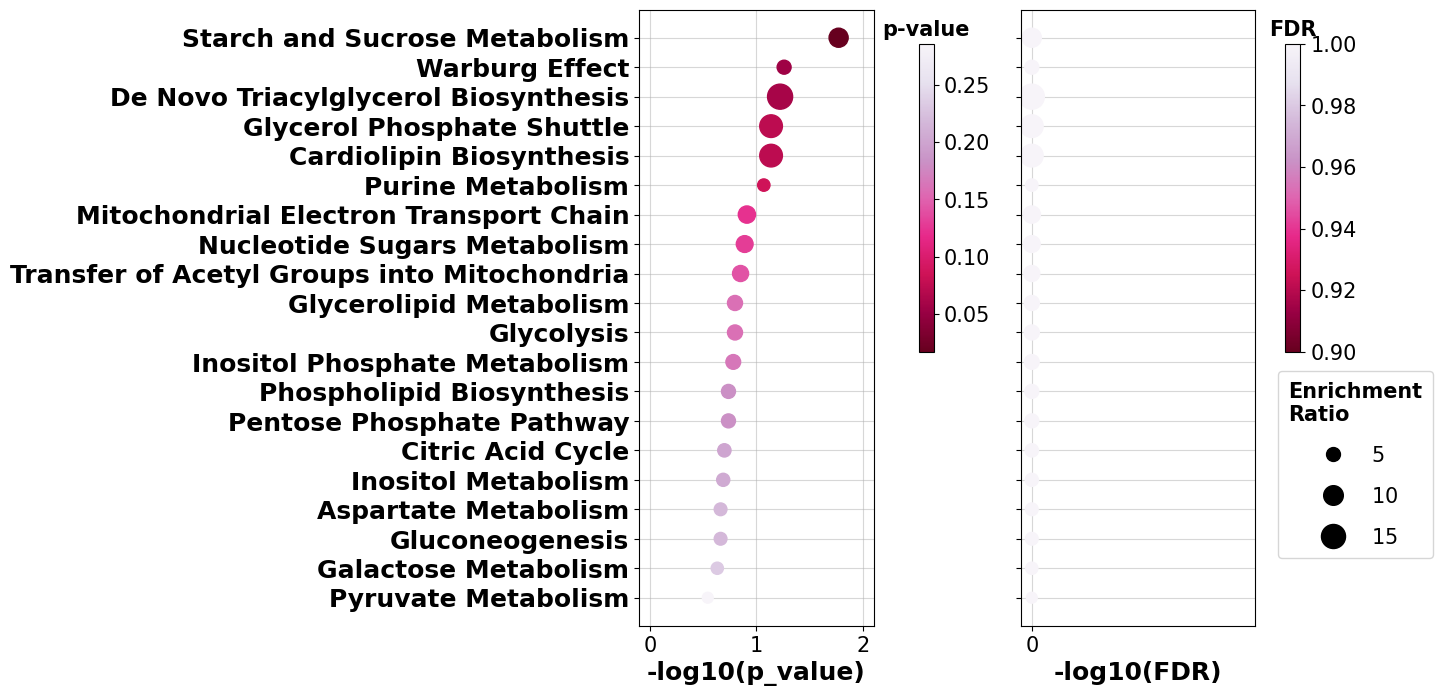

In [53]:
plot_dot(ora_data=ora_results,cluster=22,scale=20) #Plot dot plot to visualize pathway enrichment analysis result for cluster 22. Scale controls dot size.

In [54]:
ora_results = pd.read_csv('../results/pathway/ora_lipid.csv',index_col=0)
ora_results['enrichment_ratio'] = ora_results['hits']/ora_results['expected']

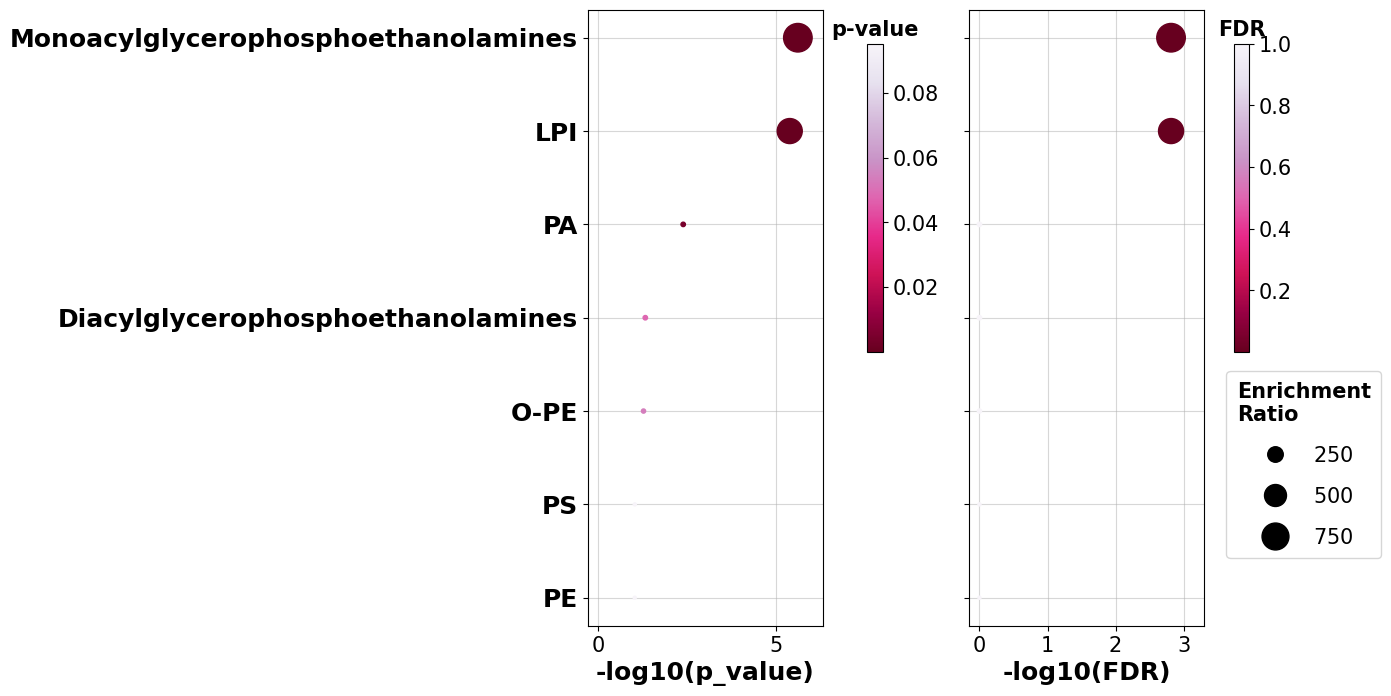

In [55]:
plot_dot(ora_results,22,0.5)

## 5.3 Network

In [56]:
ora_results = pd.read_csv('../results/pathway/ora_metgly.csv',index_col=0)
ora_results['enrichment_ratio'] = ora_results['hits']/ora_results['expected']

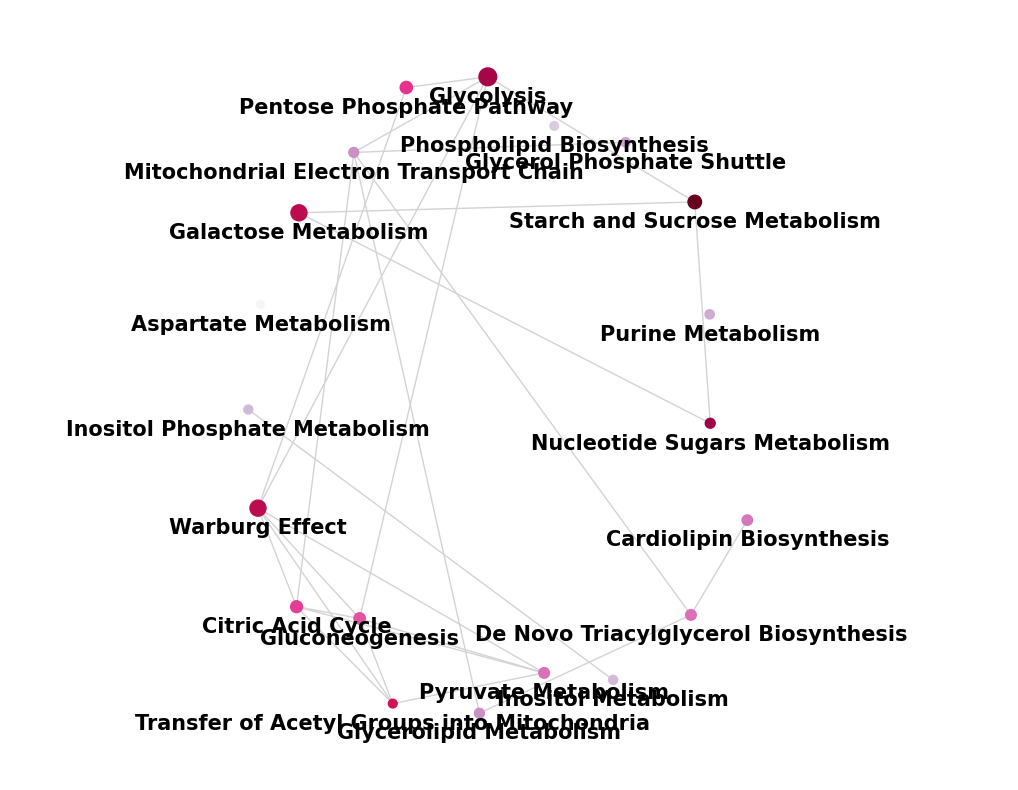

In [57]:
pathway_network(ora_data=ora_results,lib_name="smpdb_pathway",cluster=22)